In [1]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
### Solver options ###
opts = SolverOptions()
opts.square_root = false
opts.verbose = true
opts.cache=true
# opts.c1=1e-4
opts.c2 = 2.0
# opts.mu_al_update = 10.0
opts.eps_constraint = 1e-3
opts.eps_intermediate = 1e-5
opts.eps = 1e-5
opts.outer_loop_update = :uniform
opts.τ = 0.1
# opts.iterations_outerloop = 250
# opts.iterations = 1000

0.1

In [3]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)
model_euler = Model(Dynamics.quadrotor_dynamics_euler!,12,m)

TrajectoryOptimization.Model(TrajectoryOptimization.Dynamics.quadrotor_dynamics_euler!, 12, 4)

In [4]:
# Objective and constraints
Qf = 100.0*eye(n)
Q = (0.1)*eye(n)
R = (0.001)*eye(m)
tf = 5.0
dt = 0.05

Qf_euler = 100.0*eye(12)
Q_euler = (0.1)*eye(12)

# -initial state
x0 = zeros(n)
quat0 = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
x0[4:7] = quat0
x0

x0_euler = zeros(12)

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
quatf = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
xf[4:7] = quatf
xf

xf_euler = zeros(12)
xf_euler[1:3] = [20.0;20.0;0.0]

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
function cE(x,u)
    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
end

obj_uncon = UnconstrainedObjective(Q, R, Qf, tf, x0, xf)
obj_uncon_euler = UnconstrainedObjective(Q_euler, R, Qf_euler, tf, x0_euler, xf_euler)
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)
obj_con_euler = TrajectoryOptimization.ConstrainedObjective(obj_uncon_euler, u_min=u_min, u_max=u_max,cI=cI);

In [5]:
# Solver
solver_uncon = Solver(model,obj_uncon,integration=:rk4,dt=dt,opts=opts)
solver = Solver(model,obj_con,integration=:rk4,dt=dt,opts=opts)

solver_uncon_euler = Solver(model_euler,obj_uncon_euler,integration=:rk4,dt=dt,opts=opts)
solver_euler = Solver(model_euler,obj_con_euler,integration=:rk4,dt=dt,opts=opts)


# - Initial control and state trajectories
U = ones(solver.model.m, solver.N);
# X_interp = line_trajectory(solver)

In [6]:
### Solve ###
results_uncon, stats_uncon = solve(solver_uncon,U)
results, stats = solve(solver,U)

results_uncon_euler, stats_uncon_euler = solve(solver_uncon_euler,U)
results_euler, stats_euler = solve(solver_euler,U);

Solving Unconstrained Problem...
Outer loop 1 (begin)
Cost (1): 69921.34835515017

--Iteration: 1-(1)--
New cost: 39359.41108801842
- Expected improvement: 39296.01058303035
- Actual improvement: 30561.937267131747
- gradient: 79168.26353282752
- (z = 0.7777363863071042, α = 0.125)
--(v1 = 139719.14873966342, v2 = 139719.14873966397)--

--Iteration: 1-(2)--
New cost: 9880.782635559171
- Expected improvement: 49135.047726574994
- Actual improvement: 29478.628452459252
- gradient: 45513.96948466838
- (z = 0.5999511512943042, α = 0.25)
--(v1 = 78616.07636251998, v2 = 78616.07636252002)--

--Iteration: 1-(3)--
New cost: 49.35556306878793
- Expected improvement: 29496.01816661966
- Actual improvement: 9831.427072490384
- gradient: 11857.43341382417
- (z = 0.33331370413978484, α = 0.5)
--(v1 = 19664.01211107981, v2 = 19664.012111079694)--

--Iteration: 1-(4)--
New cost: 47.4944187539885
- Expected improvement: 5.749163642333204
- Actual improvement: 1.8611443147994322
- gradient: 0.052857188

New cost: 82.34845395293173
- state+control cost: 82.34845395293173
- Max constraint violation: 3.540675023105508
- Expected improvement: 19.52005438934877
- Actual improvement: 5.642317928289785
- gradient: 5833.095062045209
- (z = 0.2890523671577754, α = 0.5)
--(v1 = 13.013369592899176, v2 = 13.013369592899183)--

--Iteration: 1-(17)--
Non-finite values in rollout
New cost: 76.33335328779505
- state+control cost: 76.33335328779505
- Max constraint violation: 3.778058753627004
- Expected improvement: 8.625546170154458
- Actual improvement: 6.015100665136686
- gradient: 25509.080356263406
- (z = 0.697358816065438, α = 0.0625)
--(v1 = 64.94528881057474, v2 = 64.94528881057468)--

--Iteration: 1-(18)--
Non-finite values in rollout
New cost: 65.01439525380371
- state+control cost: 65.01439525380371
- Max constraint violation: 2.235204704964407
- Expected improvement: 19.525218626264138
- Actual improvement: 11.318958033991336
- gradient: 16797.655347176405
- (z = 0.5797096693588752, α = 0

New cost: 54.69396878187035
- state+control cost: 54.69396878187035
- Max constraint violation: 1.620710885007604
- Expected improvement: 0.0016815391293932575
- Actual improvement: 0.0005201403763379631
- gradient: 4.456756807906895e-5
- (z = 0.3093239801833473, α = 0.5)
--(v1 = 0.0011210260862621715, v2 = 0.0011210260862621721)--

--Iteration: 1-(41)--
New cost: 54.69362286584724
- state+control cost: 54.69362286584724
- Max constraint violation: 1.6254891985636206
- Expected improvement: 0.0013121006227850033
- Actual improvement: 0.00034591602311451197
- gradient: 1.772275993391906e-5
- (z = 0.2636352861263695, α = 0.5)
--(v1 = 0.0008747337485233355, v2 = 0.0008747337485233355)--

--Iteration: 1-(42)--
New cost: 54.693382045612786
- state+control cost: 54.693382045612786
- Max constraint violation: 1.6194574572654243
- Expected improvement: 0.0010743201257818334
- Actual improvement: 0.00024082023445259892
- gradient: 2.8190997096542088e-5
- (z = 0.22416059112486855, α = 0.5)
--(v1

New cost: 55.01390148551202
- state+control cost: 55.01390148551202
- Max constraint violation: 0.3786031156952774
- Expected improvement: 0.0009396281043328691
- Actual improvement: 2.7761180717789102e-5
- gradient: 2.026539616566627e-5
- (z = 0.02954485991827521, α = 0.5)
--(v1 = 0.0006264187362219128, v2 = 0.0006264187362219128)--

--Iteration: 2-(11)--
New cost: 55.01387701503639
- state+control cost: 55.01387701503639
- Max constraint violation: 0.3911656750376018
- Expected improvement: 0.0008161212608020249
- Actual improvement: 2.4470475629811972e-5
- gradient: 1.4945291797059629e-5
- (z = 0.029983872256635197, α = 0.5)
--(v1 = 0.0005440808405346833, v2 = 0.0005440808405346833)--

--Iteration: 2-(12)--
New cost: 55.01385847922538
- state+control cost: 55.01385847922538
- Max constraint violation: 0.37953909333898395
- Expected improvement: 0.0007003645605224748
- Actual improvement: 1.8535811015851777e-5
- gradient: 1.4302648672542363e-5
- (z = 0.026465946537934455, α = 0.5)
--

New cost: 55.0561635042662
- state+control cost: 55.0561635042662
- Max constraint violation: 0.015703861536572106
- Expected improvement: 4.147263092249121e-5
- Actual improvement: 1.1817791296664382e-5
- gradient: 8.710281232692063e-6
- (z = 0.28495398130759586, α = 0.5)
--(v1 = 2.764842061499414e-5, v2 = 2.7648420614994142e-5)--

--Iteration: 4-(7)--
New cost: 55.05615696803298
- state+control cost: 55.05615696803298
- Max constraint violation: 0.01579378017161659
- Expected improvement: 2.490283093027655e-5
- Actual improvement: 6.536233222220744e-6
- gradient: 3.1184348038066835e-6
- (z = 0.2624694855183743, α = 0.5)
--(v1 = 1.6601887286851034e-5, v2 = 1.6601887286851037e-5)--

--iLQR (inner loop) cost eps criteria met at iteration: 7

10.0x μ update

Outer loop 4 (end)
 -----
Outer loop 5 (begin)
Cost (5): 55.06579299829287

--Iteration: 5-(1)--
New cost: 55.05577312646316
- state+control cost: 55.05577312646316
- Max constraint violation: 0.00041612828330528373
- Expected improv

New cost: 47.52654803834238
- Expected improvement: 0.00032940580104074384
- Actual improvement: 0.00021833059857812032
- gradient: 2.6055658835477636e-6
- (z = 0.6628013164562189, α = 0.5)
--(v1 = 0.0002196038673604958, v2 = 0.00021960386736049608)--

--Iteration: 1-(20)--
New cost: 47.52633654081436
- Expected improvement: 0.0003207027607259929
- Actual improvement: 0.00021149752802074318
- gradient: 2.5587653093040347e-6
- (z = 0.6594814698257174, α = 0.5)
--(v1 = 0.00021380184048399526, v2 = 0.0002138018404839953)--

--Iteration: 1-(21)--
New cost: 47.52613597428888
- Expected improvement: 0.0003057798622362167
- Actual improvement: 0.0002005665254856126
- gradient: 2.5164774084761403e-6
- (z = 0.6559180320732625, α = 0.5)
--(v1 = 0.00020385324149081111, v2 = 0.00020385324149081117)--

--Iteration: 1-(22)--
New cost: 47.525950024783576
- Expected improvement: 0.0002850969951791364
- Actual improvement: 0.00018594950530115284
- gradient: 2.3777485546742965e-6
- (z = 0.65223242771925

Non-finite values in rollout
Non-finite values in rollout
New cost: 60.44792833819972
- state+control cost: 60.44792833819972
- Max constraint violation: 4.430382979224596
- Expected improvement: 3.4269067965511755
- Actual improvement: 2.799156049632707
- gradient: 19689.327496150363
- (z = 0.8168170936104144, α = 0.125)
--(v1 = 12.184557498848624, v2 = 12.184557498848623)--

--Iteration: 1-(15)--
Non-finite values in rollout
New cost: 57.70306197770905
- state+control cost: 57.70306197770905
- Max constraint violation: 2.3061936284086197
- Expected improvement: 4.536582096624094
- Actual improvement: 2.7448663604906756
- gradient: 12435.02474869759
- (z = 0.6050516230122394, α = 0.25)
--(v1 = 7.258531354598549, v2 = 7.258531354598555)--

--Iteration: 1-(16)--
New cost: 57.55358171062566
- state+control cost: 57.55358171062566
- Max constraint violation: 2.6952078585711767
- Expected improvement: 2.408342030741339
- Actual improvement: 0.14948026708339057
- gradient: 4398.010203722161

New cost: 54.70624226013992
- state+control cost: 54.70624226013992
- Max constraint violation: 1.8117402627384518
- Expected improvement: 8.924568956406701e-5
- Actual improvement: 4.053369849543742e-5
- gradient: 51.80314639885393
- (z = 0.45418102200150967, α = 0.5)
--(v1 = 5.949712637604199e-5, v2 = 5.949712637605003e-5)--

--Iteration: 1-(38)--
New cost: 54.706229362954545
- state+control cost: 54.706229362954545
- Max constraint violation: 1.811561347509297
- Expected improvement: 2.955643142724307e-5
- Actual improvement: 1.2897185378335507e-5
- gradient: 0.0814860168376703
- (z = 0.4363580024903742, α = 0.5)
--(v1 = 1.9704287618162776e-5, v2 = 1.9704287618160587e-5)--

--Iteration: 1-(39)--
New cost: 54.70622476127945
- state+control cost: 54.70622476127945
- Max constraint violation: 1.8118365105443228
- Expected improvement: 1.177462679238839e-5
- Actual improvement: 4.601675094306756e-6
- gradient: 0.9015789960290992
- (z = 0.3908128194161934, α = 0.5)
--(v1 = 7.849751194925

New cost: 55.07867860495973
- state+control cost: 55.07867860495973
- Max constraint violation: 0.005087308699781801
- Expected improvement: 0.00011978321327975902
- Actual improvement: 5.1645435696912045e-5
- gradient: 1344.2609725343423
- (z = 0.43115754105119747, α = 0.5)
--(v1 = 7.985547551983817e-5, v2 = 7.985547551984168e-5)--

--Iteration: 4-(6)--
New cost: 55.07865955140551
- state+control cost: 55.07865955140551
- Max constraint violation: 0.004929349187079879
- Expected improvement: 3.99896556341866e-5
- Actual improvement: 1.9053554218828594e-5
- gradient: 121.5787147478072
- (z = 0.4764620729201773, α = 0.5)
--(v1 = 2.6659770422791725e-5, v2 = 2.6659770422789756e-5)--

--Iteration: 4-(7)--
New cost: 55.07865149134736
- state+control cost: 55.07865149134736
- Max constraint violation: 0.004919611012205394
- Expected improvement: 1.6247667793183705e-5
- Actual improvement: 8.060058149794713e-6
- gradient: 4.5617248768077845
- (z = 0.4960747753087434, α = 0.5)
--(v1 = 1.083177

In [7]:
### Results ###
println("Final position: $(results.X[1:3,end])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results.result[results.termination_index]))")
println("Final position (euler): $(results_euler.X[1:3,end])\n       desired: $(obj_uncon_euler.xf[1:3])\n    Iterations: $(stats_euler["iterations"])\n Max violation: $(max_violation(results_euler.result[results_euler.termination_index]))")

Final position: [20.0, 20.0, 8.78401e-6]
       desired: [20.0, 20.0, 0.0]
    Iterations: 94
 Max violation: 0.0002723742600037049
Final position (euler): [20.0, 20.0, 8.72023e-6]
       desired: [20.0, 20.0, 0.0]
    Iterations: 67
 Max violation: 0.000319035446192828


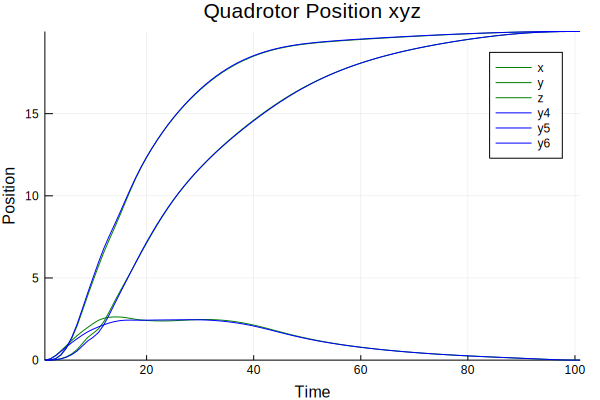

In [8]:
# Position
plot(results.X[1:3,:]',color="green",title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])
plot!(results_euler.X[1:3,:]',color="blue")

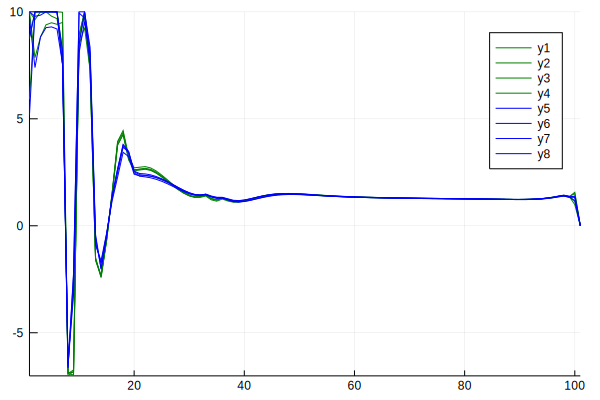

In [9]:
# Control
plot(results.U[1:m,:]',color="green")
plot!(results_euler.U[1:m,:]',color="blue")

Quaternion Animation

In [26]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
# settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
for i = 1:n_spheres
    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(results.X[1,i], results.X[2,i], results.X[3,i]))
end

Listening on 0.0.0.0:8705...
Could not open browser automatically: could not spawn `start http://127.0.0.1:8705`: no such file or directory (ENOENT)
Please open the following URL in your browser:
http://127.0.0.1:8705


INFO: Serving MeshCat visualizer at http://127.0.0.1:8705


In [29]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(results.X[1,1], results.X[2,1], results.X[3,1]),LinearMap(TrajectoryOptimization.quat2rot(results.X[4:7,1]))))

MeshCat Visualizer with path /meshcat/robot

In [30]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(results.X[1,i], results.X[2,i], results.X[3,i]),LinearMap(TrajectoryOptimization.quat2rot(results.X[4:7,i]))))
    sleep(solver.dt*2)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon.X[1,i], results_uncon_euler.X[2,i], results_uncon.X[3,i]),LinearMap(TrajectoryOptimization.quat2rot(results_uncon.X[4:7,i]))))
#     sleep(solver.dt*2)
# end


Euler Angle Animation

In [12]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

Listening on 0.0.0.0:8701...
Could not open browser automatically: could not spawn `start http://127.0.0.1:8701`: no such file or directory (ENOENT)
Please open the following URL in your browser:
http://127.0.0.1:8701


INFO: Serving MeshCat visualizer at http://127.0.0.1:8701


In [13]:
# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
# settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
for i = 1:n_spheres
    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]))
end

In [14]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(results_euler.X[1,1], results_euler.X[2,1], results_euler.X[3,1]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,1])))))

MeshCat Visualizer with path /meshcat/robot

In [15]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,i])))))
    sleep(solver_euler.dt)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon_euler.X[1,i], results_uncon_euler.X[2,i], results_uncon_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_uncon_euler.X[4:7,i])))))
#     sleep(solver_euler.dt*2)
# end

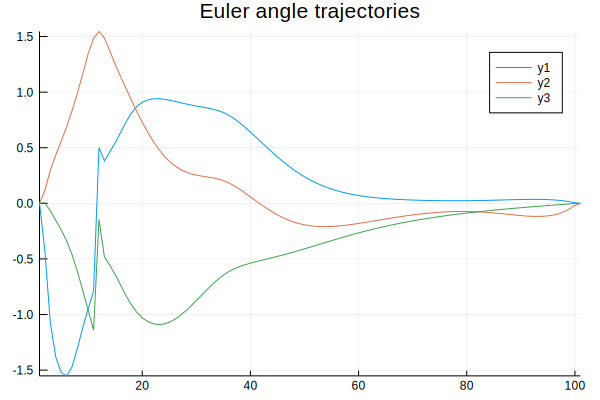

In [16]:
# Plot Euler angle trajectories
eul = zeros(3,solver.N)
for i = 1:solver.N
#     eul[:,i] = TrajectoryOptimization.quat2eul(results.X[4:7,i])
    eul[:,i] = results_euler.X[4:6,i]

end

plot(eul',title=("Euler angle trajectories"))
